### 第一步：导入库与定义常量

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

# --- PyTorch 核心库 ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# --- Torchvision 用于图像处理和模型加载 ---
import torchvision
from torchvision import datasets, models, transforms

# --- Scikit-learn 用于评估 ---
from sklearn.metrics import classification_report, confusion_matrix

print("所有库导入成功！")
print(f"PyTorch 版本: {torch.__version__}")

# --- 定义常量 ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

所有库导入成功！
PyTorch 版本: 2.7.1+cu126


### 第二步：设置、定义数据转换与路径

In [10]:
# --- 1. 设置设备 (优先使用GPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"当前使用的设备是: {device} ({torch.cuda.get_device_name(0)})")
else:
    print(f"当前使用的设备是: {device}")

# --- 2. 定义本地数据路径 ---
# 这个路径是相对于你的 .ipynb 文件而言的
# 因为 'chest_xray' 文件夹和你的 Notebook 在同一个项目目录下
base_dir = './chest_xray/' 
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# --- 3. 定义图像转换 ---
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

当前使用的设备是: cuda (NVIDIA GeForce RTX 4060 Ti)


### 第三步：加载数据并创建 DataLoaders

In [11]:
# --- 1. 使用 ImageFolder 加载完整训练数据 ---
full_train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

# --- 2. 分割数据集 ---
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# --- 3. 为验证集应用不同的转换 ---
val_dataset.dataset = copy.deepcopy(full_train_dataset)
val_dataset.dataset.transform = data_transforms['val']

# --- 4. 创建测试集 ---
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['val'])

# --- 5. 创建 DataLoaders ---
# 在Windows上，如果DataLoader报错，可以尝试将 num_workers 设置为 0
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2),
    'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
class_names = full_train_dataset.classes

print(f"训练集大小: {dataset_sizes['train']}")
print(f"验证集大小: {dataset_sizes['val']}")
print(f"测试集大小: {dataset_sizes['test']}")
print(f"类别名称: {class_names}")

训练集大小: 4172
验证集大小: 1044
测试集大小: 624
类别名称: ['NORMAL', 'PNEUMONIA']


### 第四步：处理类别不平衡

In [12]:
# 1. 从完整数据集中获取所有标签，并转换为NumPy数组
all_targets = np.array(train_dataset.dataset.targets)

# 2. 获取属于训练集的索引列表
train_indices = train_dataset.indices

# 3. 使用训练集索引，从所有标签中筛选出只属于训练集的标签
train_labels = all_targets[train_indices]

# 4. 对只包含训练集标签的列表进行计数
train_class_counts = np.bincount(train_labels)

# 基于正确的计数进行计算
neg_count = train_class_counts[class_names.index('NORMAL')]
pos_count = train_class_counts[class_names.index('PNEUMONIA')]

# 计算 pos_weight
# 公式: weight_for_positive_class = num_negative_samples / num_positive_samples
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float).to(device)

print(f"训练集中的正常样本数: {neg_count}, 肺炎样本数: {pos_count}")
print(f"计算得到的 pos_weight: {pos_weight.item():.4f}")

训练集中的正常样本数: 1085, 肺炎样本数: 3087
计算得到的 pos_weight: 0.3515


### 第五步：构建模型

In [13]:
# 1. 加载预训练模型
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# 2. 冻结所有基础模型的参数
for param in model.parameters():
    param.requires_grad = False

# 3. 替换分类头
# MobileNetV2 的分类器是一个包含 nn.Linear 的 nn.Sequential
# 我们需要替换这个 nn.Linear 层
num_ftrs = model.classifier[1].in_features
# 注意：输出为1，并且不加激活函数，因为 nn.BCEWithLogitsLoss 会帮我们处理
model.classifier[1] = nn.Linear(num_ftrs, 1)

# 4. 将模型移动到GPU
model = model.to(device)

# 5. 定义损失函数、优化器和学习率调度器
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# 初始阶段只优化我们新添加的分类头的参数
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
# 当验证损失不再下降时，自动降低学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

print("模型构建完毕。")

模型构建完毕。


### 第六步：编写训练和评估循环

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # 用于保存历史记录
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
            else:
                model.eval()   # 设置模型为评估模式

            running_loss = 0.0
            running_corrects = 0

            # 遍历数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().view(-1, 1) # 转换为正确形状 [B, 1]

                # 梯度清零
                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs) > 0.5
                    loss = criterion(outputs, labels)

                    # 只在训练阶段进行反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计损失和准确率
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 如果是验证阶段，并且找到了更好的模型，就保存它
            if phase == 'val':
                scheduler.step(epoch_loss) # 学习率调度器根据验证损失调整
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_pneumonia_model.pth')
                    print(f'Validation accuracy improved. Saving model to best_pneumonia_model.pth')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model, history

### 第七步：开始训练

In [15]:
# 开始训练
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=15)

Epoch 1/15
----------
train Loss: 0.3428 Acc: 0.6616
val Loss: 0.3074 Acc: 0.8151
Validation accuracy improved. Saving model to best_pneumonia_model.pth

Epoch 2/15
----------
train Loss: 0.3099 Acc: 0.8140
val Loss: 0.2808 Acc: 0.7768

Epoch 3/15
----------
train Loss: 0.2885 Acc: 0.8133
val Loss: 0.2603 Acc: 0.7749

Epoch 4/15
----------
train Loss: 0.2710 Acc: 0.8190
val Loss: 0.2486 Acc: 0.7634

Epoch 5/15
----------
train Loss: 0.2557 Acc: 0.8255
val Loss: 0.2354 Acc: 0.7701

Epoch 6/15
----------
train Loss: 0.2466 Acc: 0.8262
val Loss: 0.2273 Acc: 0.7720

Epoch 7/15
----------
train Loss: 0.2358 Acc: 0.8399
val Loss: 0.2196 Acc: 0.7807

Epoch 8/15
----------
train Loss: 0.2341 Acc: 0.8214
val Loss: 0.2150 Acc: 0.7787

Epoch 9/15
----------
train Loss: 0.2249 Acc: 0.8322
val Loss: 0.2125 Acc: 0.7835

Epoch 10/15
----------
train Loss: 0.2236 Acc: 0.8281
val Loss: 0.2067 Acc: 0.7921

Epoch 11/15
----------
train Loss: 0.2222 Acc: 0.8245
val Loss: 0.2028 Acc: 0.7902

Epoch 12/15
--

### 第八步：微调训练

In [17]:
# --- 1. 加载第一阶段训练出的最佳模型权重 ---
print("--- 加载第一阶段的最佳模型权重 ---")
model.load_state_dict(torch.load('best_pneumonia_model.pth'))


# --- 2. 解冻模型参数以进行微调 ---
print("--- 解冻模型参数，准备微调 ---")
# 将所有层的 requires_grad 设置为 True，使它们可以被训练
for param in model.parameters():
    param.requires_grad = True

# 也可以选择只解冻部分层，但对于MobileNetV2，全部解冻配合极低学习率效果通常不错


# --- 3. 为微调阶段创建新的优化器和学习率调度器 ---
# 关键：必须使用一个非常非常低的学习率，以防破坏预训练权重
optimizer_ft = optim.Adam(model.parameters(), lr=1e-5)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.2, patience=2)

# --- 4. 调用之前定义的 train_model 函数，开始第二阶段训练 ---
print("\n--- 开始第二阶段：微调训练 ---")
# 给它10-15轮的时间进行精细调整
fine_tune_epochs = 15
model, history_fine = train_model(model, criterion, optimizer_ft, scheduler_ft, num_epochs=fine_tune_epochs)

--- 加载第一阶段的最佳模型权重 ---
--- 解冻模型参数，准备微调 ---

--- 开始第二阶段：微调训练 ---
Epoch 1/15
----------
train Loss: 0.3017 Acc: 0.8087
val Loss: 0.2533 Acc: 0.7826
Validation accuracy improved. Saving model to best_pneumonia_model.pth

Epoch 2/15
----------
train Loss: 0.2522 Acc: 0.8274
val Loss: 0.1986 Acc: 0.8161
Validation accuracy improved. Saving model to best_pneumonia_model.pth

Epoch 3/15
----------
train Loss: 0.2142 Acc: 0.8317
val Loss: 0.1724 Acc: 0.8238
Validation accuracy improved. Saving model to best_pneumonia_model.pth

Epoch 4/15
----------
train Loss: 0.1790 Acc: 0.8595
val Loss: 0.1557 Acc: 0.8362
Validation accuracy improved. Saving model to best_pneumonia_model.pth

Epoch 5/15
----------
train Loss: 0.1617 Acc: 0.8674
val Loss: 0.1403 Acc: 0.8467
Validation accuracy improved. Saving model to best_pneumonia_model.pth

Epoch 6/15
----------
train Loss: 0.1522 Acc: 0.8794
val Loss: 0.1292 Acc: 0.8554
Validation accuracy improved. Saving model to best_pneumonia_model.pth

Epoch 7/15
--

### 第九步：最终评估


--- 最终分类报告 (Test Set) ---
              precision    recall  f1-score   support

      NORMAL       0.94      0.84      0.89       234
   PNEUMONIA       0.91      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624


--- 最终混淆矩阵 (Test Set) ---


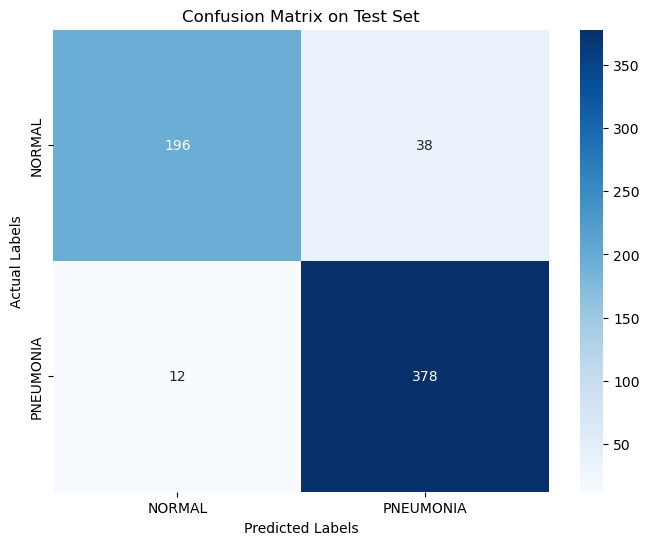

In [ ]:
# --- 1. 构建模型结构 ---
final_model = models.mobilenet_v2()
num_ftrs = final_model.classifier[1].in_features
final_model.classifier[1] = nn.Linear(num_ftrs, 1)

# --- 2. 加载训练好的最佳权重 ---
# 加载在训练过程中保存的、性能最好的那个模型文件
model_path = 'best_pneumonia_model.pth' # 确保文件名与训练时保存的一致
final_model.load_state_dict(torch.load(model_path))

# --- 3. 将模型移动到GPU并设置为评估模式 ---
final_model = final_model.to(device)
final_model.eval() 关闭 Dropout 等只在训练时使用的层

# --- 4. 在测试集上进行预测 ---
all_labels = []
all_preds = []

# with torch.no_grad() 可以关闭梯度计算，节省显存并加速预测
with torch.no_grad():
    # 遍历测试集数据加载器
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        
        outputs = final_model(inputs)
        
        # 将模型的输出（logits）通过sigmoid转换为概率，再根据0.5的阈值转换为类别（0或1）
        preds = torch.sigmoid(outputs) > 0.5
        
        # 收集所有真实标签和预测标签
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy().flatten())

# --- 5. 打印最终评估报告和混淆矩阵 ---
print("\n--- 最终分类报告 (Test Set) ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("\n--- 最终混淆矩阵 (Test Set) ---")
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Test Set')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()